In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from utils import load_series_dfs
from pathlib import Path
import time
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os, re, time
import pickle
import json, numpy as np, pandas as pd
from tslearn.metrics import cdist_dtw
from tslearn.preprocessing import TimeSeriesResampler

In [2]:
with open("../data/series_by_bin.pkl", "rb") as f:
    series_by_bin_loaded = pickle.load(f)

In [3]:
series_by_bin_loaded.keys()

dict_keys(['0–5%', '10–15%', '5–10%', '20–25%', '>30%', '25–30%'])

In [4]:
assignment_auto = pd.read_csv("../data/assignments/assignment_auto.csv")

assignment_auto = assignment_auto [['bin', 'series_key', 'assigned_medoid', 'distance']]

assignment_auto.head()

,bin,series_key,assigned_medoid,distance
0,0–5%,FL_00024360.PLAN.MengeHH.2,CV_00003432.PLAN.Menge,3.791466e+01
1,0–5%,FL_00024360.PLAN.MengeGA,FL_00024360.PLAN.MengeGA,5.527229e-07
2,0–5%,FL_00352244.PLAN.MengeKW,CV_00003432.PLAN.Menge,1.212620e+01
3,0–5%,FL_00352244.PLAN.MengeGA,CV_00003432.PLAN.Menge,2.005376e+01
4,0–5%,FL_00352251.PLAN.MengeGA,CV_00003432.PLAN.Menge,1.880089e+01


In [5]:
assignment_fixed = pd.read_csv("../data/assignments/assignment_minimaler_rmse.csv")

assignment_fixed = assignment_fixed[['bin', 'series_key', 'assigned_medoid', 'distance']]

assignment_fixed.head()

,bin,series_key,assigned_medoid,distance
0,0–5%,FL_00024360.PLAN.MengeHH.2,CV_00003432.PLAN.Menge,3.791466e+01
1,0–5%,FL_00024360.PLAN.MengeGA,FL_00024360.PLAN.MengeGA,5.527229e-07
2,0–5%,FL_00352244.PLAN.MengeKW,CV_00003432.PLAN.Menge,1.212620e+01
3,0–5%,FL_00352244.PLAN.MengeGA,CV_00003432.PLAN.Menge,2.005376e+01
4,0–5%,FL_00352251.PLAN.MengeGA,CV_00003432.PLAN.Menge,1.880089e+01


In [34]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
from typing import Dict, Tuple, List, Optional
import matplotlib.pyplot as plt

# =========================
# SETTINGS
# =========================
BASE_DIR    = Path("../data")
MODELS_DIR  = BASE_DIR / "sarimax_models"
ASSIGN_FILE = BASE_DIR / "assignments" / "assignment_auto.csv"
OUT_DIR     = BASE_DIR / "experiment_results"
IMPUTE_DIR  = OUT_DIR / "imputed_series"   # <— hier landen die Parquet-Dateien
FREQ        = "h"
TARGET_COL  = "consumption"
GAP_WINDOWS = {"short6h": (3, 6), "day24h": (2, 24), "long72h": (1, 72)}
RANDOM_SEED = 42

FEATURE_SETS = {
    "rmse_toleranz": ['hour', 'w_tl', 'w_ff', 'w_tb10', 'w_tb20', 'CEGH_WAP', 'THE_WAP'],
    "bester_score":  ['w_tl','w_tb10'],
    "minimaler_rmse":['hour','weekday','month','is_weekend','w_tl','w_rf','w_ff','w_ffx',
                      'w_cglo','w_so_h','w_rr','w_tb10','w_tb20','CEGH_WAP','THE_WAP']
}
TIME_FEATS = {"hour","weekday","month","is_weekend"}

# =========================
# HELPERS
# =========================
def ensure_outdir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def load_assignments_csv(p: Path) -> pd.DataFrame:
    if not p.exists():
        raise FileNotFoundError(f"Assignment-Datei fehlt: {p}")
    df = pd.read_csv(p)
    required = {"series_key","assigned_medoid","bin"}
    if not required.issubset(df.columns):
        miss = required - set(df.columns)
        raise KeyError(f"Assignment-Spalten fehlen: {miss}")
    return df

def model_path_for(medoid: str, variant: str) -> Path:
    return MODELS_DIR / f"{medoid}__{variant}.pkl"

def load_model_safe(medoid: str, variant: str):
    p = model_path_for(medoid, variant)
    if not p.exists():
        raise FileNotFoundError(f"Modell fehlt: {p.name}")
    with open(p, "rb") as f:
        return pickle.load(f)

def select_exog(df: pd.DataFrame, features: List[str]) -> Tuple[pd.DataFrame, List[str]]:
    missing = [c for c in features if c not in df.columns]
    return df[[c for c in features if c in df.columns]], missing

def metrics(y_true: pd.Series, y_pred: pd.Series) -> Dict[str, float]:
    mask = y_true.notna() & y_pred.notna()
    if mask.sum() == 0:
        return {"rmse": np.nan, "mae": np.nan, "mape": np.nan}
    e = (y_true[mask] - y_pred[mask])
    rmse = float(np.sqrt(np.mean(np.square(e))))
    mae  = float(np.mean(np.abs(e)))
    denom = y_true[mask].replace(0, np.nan)
    mape = float(np.mean(np.abs(e / denom))) * 100.0
    return {"rmse": rmse, "mae": mae, "mape": mape}

def random_gap_mask(idx: pd.DatetimeIndex, n_windows: int, win_len_hours: int, rng: np.random.Generator) -> pd.Series:
    mask = pd.Series(False, index=idx)
    if len(idx) < win_len_hours:
        return mask
    positions = np.arange(0, len(idx) - win_len_hours + 1)
    rng.shuffle(positions)
    starts = []
    for pos in positions:
        if all(abs(pos - s) >= win_len_hours for s in starts):
            starts.append(pos)
            if len(starts) >= n_windows:
                break
    for s in starts:
        sel = idx[s : s + win_len_hours]
        mask.loc[sel] = True
    return mask

def inject_gaps(series_df: pd.DataFrame, patterns: Dict[str, Tuple[int, int]], rng: np.random.Generator) -> Dict[str, pd.Series]:
    idx = series_df.index
    return {name: random_gap_mask(idx, n, L, rng) for name, (n, L) in patterns.items()}

def get_model_index(res) -> pd.DatetimeIndex:
    # Versuch 1: direkt aus dem Modell
    idx = getattr(res.model, "_index", None)
    if isinstance(idx, pd.DatetimeIndex):
        return idx
    # Versuch 2: aus res.data.dates rekonstruieren
    if getattr(res, "data", None) is not None and getattr(res.data, "dates", None) is not None:
        start = pd.to_datetime(res.data.dates[0])
        try:
            freq = getattr(res.model.data.row_labels, "freqstr", None) or "H"
        except Exception:
            freq = "H"
        return pd.date_range(start=start, periods=int(res.nobs), freq=freq)
    raise ValueError("Konnte den Trainingsindex des Modells nicht ermitteln.")

def impute_with_sarimax_aligned(res, endog: pd.Series, exog: pd.DataFrame) -> pd.Series:
    # 1) Auf Trainingsindex ausrichten
    model_idx = get_model_index(res)
    y_aligned = endog.reindex(model_idx)
    x_aligned = exog.reindex(model_idx)
    if x_aligned.isna().any().any():
        x_aligned = x_aligned.ffill().bfill()
    # 2) Vorhersage auf exakt dieser Spanne
    pred = res.get_prediction(start=model_idx[0], end=model_idx[-1], exog=x_aligned).predicted_mean
    # 3) Zurück auf Originalindex und nur NaNs füllen
    out = endog.copy()
    needs = out.isna()
    common = out.index.intersection(model_idx)
    fill_mask = needs.loc[common]
    out.loc[fill_mask.index] = pred.loc[fill_mask.index]
    return out

def prepare_series_for_imputation(
    df_raw: pd.DataFrame,
    target_col: str = "consumption",
    exog_cols: Optional[List[str]] = None,
    freq: str = "h",
) -> pd.DataFrame:
    df = df_raw.copy()
    idx = pd.to_datetime(df.index)
    if getattr(idx, "tz", None) is not None:
        idx = idx.tz_convert("UTC").tz_localize(None)
    df.index = idx
    df = df[~df.index.duplicated(keep="first")].sort_index()
    df = df.asfreq(freq)

    # Zeitfeatures sicherstellen
    if "hour" not in df.columns: df["hour"] = df.index.hour
    if "weekday" not in df.columns: df["weekday"] = df.index.weekday
    if "month" not in df.columns: df["month"] = df.index.month
    if "is_weekend" not in df.columns:
        df["is_weekend"] = (df.index.weekday >= 5).astype(int)
    else:
        df["is_weekend"] = df["is_weekend"].astype(int, errors="ignore")

    # Exogene (alles außer Target und Zeitfeatures), sanft auffüllen
    if exog_cols is None:
        exog_cols = [c for c in df.columns if c not in {target_col, *TIME_FEATS}]
    exog_cols_existing = [c for c in exog_cols if c in df.columns]
    if exog_cols_existing:
        df[exog_cols_existing] = (
            df[exog_cols_existing].ffill().bfill()
                                   .interpolate(method="time", limit_direction="both")
        )
    return df

import re
import unicodedata

INVALID_WIN_CHARS = r'[<>:"/\\|?*]'  # verbotene Zeichen auf Windows

def sanitize_for_path(s: str) -> str:
    # Unicode normalisieren und trimmen
    s = unicodedata.normalize("NFKC", s).strip()
    # Sonderfall: führendes ">" abfangen
    if s.startswith(">"):
        s = "gt" + s[1:]   # z.B. ">30%" -> "gt30%"
    # Verbotene Zeichen ersetzen
    s = re.sub(INVALID_WIN_CHARS, "_", s)
    # Keine Leerzeichen/Punkte am Ende
    s = s.rstrip(" .")
    return s or "unnamed"

# =========================
# MAIN EXPERIMENT RUNNER
# =========================
# =========================
SAVE_SERIES_PARQUET = True
SAVE_SERIES_PNG     = False  # auf True setzen, wenn du Plots pro Fall als PNG willst
IMPUTED_DIR         = OUT_DIR / "imputed_series"

def _safe(s: str) -> str:
    """Datei-/Ordner-sichere Namen (ersetzt problematische Zeichen)."""
    return (
        str(s)
        .replace("/", "_")
        .replace("\\", "_")
        .replace(":", "_")
        .replace("*", "_")
        .replace("?", "_")
        .replace('"', "_")
        .replace("<", "_")
        .replace(">", "_")
        .replace("|", "_")
    )

def run_experiments_with_diagnostics(series_by_bin_loaded: Dict[str, Dict[str, pd.DataFrame]]):
    print("[PATH] CWD:      ", Path.cwd())
    print("[PATH] BASE_DIR: ", BASE_DIR.resolve())
    print("[PATH] OUT_DIR:  ", OUT_DIR.resolve())
    print("[PATH] ASSIGN:   ", ASSIGN_FILE.resolve(), "exists:", ASSIGN_FILE.exists())

    rng = np.random.default_rng(RANDOM_SEED)
    ensure_outdir(OUT_DIR)
    ensure_outdir(IMPUTED_DIR)

    # 1) Assignments
    try:
        assignments = load_assignments_csv(ASSIGN_FILE)
    except Exception as e:
        print(f"[FATAL] {e}")
        return

    assign_lookup = assignments.set_index("series_key")["assigned_medoid"].to_dict()
    bin_lookup    = assignments.set_index("series_key")["bin"].to_dict()

    variants = list(FEATURE_SETS.keys())
    print("[INFO] Varianten:", variants)

    results_rows, skip_rows = [], []
    first_success_case = None

    for bin_key, series_map in series_by_bin_loaded.items():
        for series_key, df_raw in series_map.items():

            # 0) Target da?
            if TARGET_COL not in df_raw.columns:
                skip_rows.append({
                    "series_key": series_key, "bin": bin_key, "variant": None, "gap_pattern": None,
                    "stage": "target_check", "reason": f"Target '{TARGET_COL}' fehlt"
                })
                continue

            # 1) Prep (Target NICHT auffüllen)
            try:
                df = prepare_series_for_imputation(
                    df_raw=df_raw, target_col=TARGET_COL, exog_cols=None, freq=FREQ
                )
            except Exception as e:
                skip_rows.append({
                    "series_key": series_key, "bin": bin_key, "variant": None, "gap_pattern": None,
                    "stage": "prep", "reason": str(e)
                })
                continue

            # 2) Medoid
            medoid = assign_lookup.get(series_key)
            if medoid is None:
                skip_rows.append({
                    "series_key": series_key, "bin": bin_key, "variant": None, "gap_pattern": None,
                    "stage": "assignment", "reason": "kein assigned_medoid"
                })
                continue

            # 3) synthetische Lücken
            gap_masks = inject_gaps(df, GAP_WINDOWS, rng=rng)

            # 4) Varianten durchgehen
            for variant in variants:
                feats = FEATURE_SETS[variant]

                # 4a) Modell laden
                try:
                    res = load_model_safe(medoid, variant)
                except Exception as e:
                    skip_rows.append({
                        "series_key": series_key, "bin": bin_key, "variant": variant, "gap_pattern": None,
                        "stage": "model_load", "reason": str(e)
                    })
                    continue

                # 4b) Exogene gemäß Variante
                exog_full, missing = select_exog(df, feats)
                if missing:
                    skip_rows.append({
                        "series_key": series_key, "bin": bin_key, "variant": variant, "gap_pattern": None,
                        "stage": "exog_missing", "reason": f"fehlen: {missing}"
                    })
                    if exog_full.shape[1] == 0:
                        continue

                # Reihenfolge/Set der Exogs mit Trainings-Modell abgleichen
                trained_names = getattr(getattr(res, "model", None), "exog_names", None)
                if trained_names is not None:
                    miss = [c for c in trained_names if c not in exog_full.columns]
                    extra= [c for c in exog_full.columns if c not in trained_names]
                    if miss or extra:
                        skip_rows.append({
                            "series_key": series_key, "bin": bin_key, "variant": variant, "gap_pattern": None,
                            "stage": "exog_mismatch", "reason": f"missing:{miss} extra:{extra}"
                        })
                        continue
                    exog_full = exog_full[trained_names]

                # 4c) je Gap-Pattern
                for gap_name, mask in gap_masks.items():
                    y_true = df[TARGET_COL].copy()
                    y_nan  = y_true.copy()
                    if mask.sum() == 0:
                        skip_rows.append({
                            "series_key": series_key, "bin": bin_key, "variant": variant, "gap_pattern": gap_name,
                            "stage": "gap_empty", "reason": "kein synthetischer Gap möglich"
                        })
                        continue
                    # synthetische NaNs setzen
                    y_nan.loc[mask[mask].index] = np.nan

                    # 4d) Imputation (WICHTIG: aligned apply)
                    try:
                        y_imp = impute_with_sarimax_aligned(res, y_nan, exog_full)
                    except Exception as e:
                        skip_rows.append({
                            "series_key": series_key, "bin": bin_key, "variant": variant, "gap_pattern": gap_name,
                            "stage": "predict", "reason": str(e)
                        })
                        continue

                    # 4e) Metriken nur im Gap
                    eval_mask = mask & y_true.notna()
                    m = metrics(y_true[eval_mask], y_imp[eval_mask])

                    results_rows.append({
                        "bin": bin_key,
                        "series_key": series_key,
                        "assignment_bin": bin_lookup.get(series_key, np.nan),
                        "assigned_medoid": medoid,
                        "variant": variant,
                        "features": ",".join(feats),
                        "gap_pattern": gap_name,
                        "n_eval_points": int(eval_mask.sum()),
                        **m
                    })

                    # 4f) (neu) Diagnose-Datei speichern
                    if SAVE_SERIES_PARQUET or SAVE_SERIES_PNG:
                        var_dir = IMPUTED_DIR / _safe(variant) / _safe(bin_key)
                        ensure_outdir(var_dir)
                        base_fn = f"{_safe(series_key)}__{_safe(gap_name)}"
                        if SAVE_SERIES_PARQUET:
                            pd.DataFrame({
                                "y_true": y_true,
                                "y_with_nan": y_nan,
                                "y_imputed": y_imp,
                                "gap_mask": mask.astype(int)
                            }).to_parquet(var_dir / f"{base_fn}.parquet")
                        if SAVE_SERIES_PNG:
                            import matplotlib.pyplot as plt
                            plt.figure(figsize=(14,4))
                            plt.plot(y_true.index, y_true.values, label="Original", linewidth=1)
                            plt.plot(y_imp.index,  y_imp.values,  label="Imputation", linewidth=1, alpha=0.8)
                            plt.fill_between(mask.index, y_true.min(), y_true.max(),
                                             where=mask.values, alpha=0.15, label="synthetische Lücke")
                            plt.legend(); plt.tight_layout()
                            plt.title(f"{series_key} – {variant} – {gap_name}")
                            plt.savefig(var_dir / f"{base_fn}.png", dpi=120)
                            plt.close()

                    if first_success_case is None:
                        first_success_case = (series_key, bin_key, variant, gap_name)

    # 5) Logs schreiben
    ensure_outdir(OUT_DIR)
    debug_df = pd.DataFrame(skip_rows)
    res_df   = pd.DataFrame(results_rows)

    debug_path = OUT_DIR / "debug_skips.csv"
    res_path   = OUT_DIR / "experiment_summary.csv"

    debug_df.to_csv(debug_path, index=False)
    print(f"[OK] Skip-Log: {debug_path.resolve()} (rows={len(debug_df)})")

    if not res_df.empty:
        res_df.to_csv(res_path, index=False)
        print(f"[OK] Ergebnisse: {res_path.resolve()} (rows={len(res_df)})")
    else:
        print("[WARN] Keine Ergebnisse erzeugt.")

    if first_success_case:
        sk, bk, var, gp = first_success_case
        print(f"[SMOKE] Erste erfolgreiche Kombination: {sk} | {bk} | {var} | {gp}")
    else:
        print("[SMOKE] Keine erfolgreiche Kombination gefunden — bitte Skip-Log ansehen.")

# =========================
# PLOT-FUNKTION
# =========================
def plot_imputation(series_key: str,
                    variant: str,
                    bin_key: str,
                    gap_pattern: str,
                    base_dir: Path = IMPUTE_DIR,
                    target_col: str = TARGET_COL):
    safe_bin = sanitize_for_path(bin_key)
    fn = Path(base_dir) / variant / safe_bin / f"{series_key}__{gap_pattern}.parquet"
    if not fn.exists():
        raise FileNotFoundError(f"Datei nicht gefunden: {fn}")
    df = pd.read_parquet(fn)

    plt.figure(figsize=(12,5))
    plt.plot(df.index, df[target_col], label="Original", alpha=0.7, lw=2)
    plt.plot(df.index, df[f"{target_col}_imputed"], label="Imputation", alpha=0.7, lw=2)

    mask = df["gap_mask"].astype(bool)
    if mask.any():
        ymin = np.nanmin(df[[target_col, f"{target_col}_imputed"]].values)
        ymax = np.nanmax(df[[target_col, f"{target_col}_imputed"]].values)
        plt.fill_between(df.index, ymin, ymax, where=mask, alpha=0.15, label="synthetische Lücke")

    plt.title(f"{series_key} – {variant} – {gap_pattern}")
    plt.xlabel("Zeit")
    plt.ylabel("Verbrauch")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Beispiel-Aufruf nach dem Run:
# plot_imputation("FL_00024360.PLAN.MengeHH.2", "minimaler_rmse", "0–5%", "day24h")



In [20]:
series_by_bin_loaded2 = series_by_bin_loaded[">30%"]

In [22]:
run_experiments_with_diagnostics({'>30%': series_by_bin_loaded['>30%']})

[SMOKE] Erste erfolgreiche Kombination: FL_00352208.PLAN.MengeKW | >30% | rmse_toleranz | short6h


In [35]:
run_experiments_with_diagnostics(series_by_bin_loaded)

[PATH] CWD:       C:\Users\johan\Documents\FH_Master\notebooks
[PATH] BASE_DIR:  C:\Users\johan\Documents\FH_Master\data
[PATH] OUT_DIR:   C:\Users\johan\Documents\FH_Master\data\experiment_results
[PATH] ASSIGN:    C:\Users\johan\Documents\FH_Master\data\assignments\assignment_auto.csv exists: True
[INFO] Varianten: ['rmse_toleranz', 'bester_score', 'minimaler_rmse']
[OK] Skip-Log: C:\Users\johan\Documents\FH_Master\data\experiment_results\debug_skips.csv (rows=0)
[OK] Ergebnisse: C:\Users\johan\Documents\FH_Master\data\experiment_results\experiment_summary.csv (rows=2871)
[SMOKE] Erste erfolgreiche Kombination: FL_00024360.PLAN.MengeHH.2 | 0–5% | rmse_toleranz | short6h


In [15]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
from typing import Dict, Tuple, List, Optional
import matplotlib.pyplot as plt

# =========================
# SETTINGS
# =========================
BASE_DIR    = Path("../data")
MODELS_DIR  = BASE_DIR / "sarimax_models"
ASSIGN_FILE = BASE_DIR / "assignments" / "assignment_auto.csv"
OUT_DIR     = BASE_DIR / "experiment_results"
IMPUTE_DIR  = OUT_DIR / "imputed_series"   # <— hier landen die Parquet-Dateien
FREQ        = "h"
TARGET_COL  = "consumption"
GAP_WINDOWS = {"short6h": (3, 6), "day24h": (2, 24), "long72h": (1, 72)}
RANDOM_SEED = 42

FEATURE_SETS = {
    "rmse_toleranz": ['hour', 'w_tl', 'w_ff', 'w_tb10', 'w_tb20', 'CEGH_WAP', 'THE_WAP'],
    "bester_score":  ['w_tl','w_tb10'],
    "minimaler_rmse":['hour','weekday','month','is_weekend','w_tl','w_rf','w_ff','w_ffx',
                      'w_cglo','w_so_h','w_rr','w_tb10','w_tb20','CEGH_WAP','THE_WAP']
}
TIME_FEATS = {"hour","weekday","month","is_weekend"}

# =========================
# HELPERS
# =========================
def ensure_outdir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def load_assignments_csv(p: Path) -> pd.DataFrame:
    if not p.exists():
        raise FileNotFoundError(f"Assignment-Datei fehlt: {p}")
    df = pd.read_csv(p)
    required = {"series_key","assigned_medoid","bin"}
    if not required.issubset(df.columns):
        miss = required - set(df.columns)
        raise KeyError(f"Assignment-Spalten fehlen: {miss}")
    return df

def model_path_for(medoid: str, variant: str) -> Path:
    return MODELS_DIR / f"{medoid}__{variant}.pkl"

def load_model_safe(medoid: str, variant: str):
    p = model_path_for(medoid, variant)
    if not p.exists():
        raise FileNotFoundError(f"Modell fehlt: {p.name}")
    with open(p, "rb") as f:
        return pickle.load(f)

def select_exog(df: pd.DataFrame, features: List[str]) -> Tuple[pd.DataFrame, List[str]]:
    missing = [c for c in features if c not in df.columns]
    return df[[c for c in features if c in df.columns]], missing

def metrics(y_true: pd.Series, y_pred: pd.Series) -> Dict[str, float]:
    mask = y_true.notna() & y_pred.notna()
    if mask.sum() == 0:
        return {"rmse": np.nan, "mae": np.nan, "mape": np.nan}
    e = (y_true[mask] - y_pred[mask])
    rmse = float(np.sqrt(np.mean(np.square(e))))
    mae  = float(np.mean(np.abs(e)))
    denom = y_true[mask].replace(0, np.nan)
    mape = float(np.mean(np.abs(e / denom))) * 100.0
    return {"rmse": rmse, "mae": mae, "mape": mape}

def random_gap_mask(idx: pd.DatetimeIndex, n_windows: int, win_len_hours: int, rng: np.random.Generator) -> pd.Series:
    mask = pd.Series(False, index=idx)
    if len(idx) < win_len_hours:
        return mask
    positions = np.arange(0, len(idx) - win_len_hours + 1)
    rng.shuffle(positions)
    starts = []
    for pos in positions:
        if all(abs(pos - s) >= win_len_hours for s in starts):
            starts.append(pos)
            if len(starts) >= n_windows:
                break
    for s in starts:
        sel = idx[s : s + win_len_hours]
        mask.loc[sel] = True
    return mask

def inject_gaps(series_df: pd.DataFrame, patterns: Dict[str, Tuple[int, int]], rng: np.random.Generator) -> Dict[str, pd.Series]:
    idx = series_df.index
    return {name: random_gap_mask(idx, n, L, rng) for name, (n, L) in patterns.items()}

def get_model_index(res) -> pd.DatetimeIndex:
    # Versuch 1: direkt aus dem Modell
    idx = getattr(res.model, "_index", None)
    if isinstance(idx, pd.DatetimeIndex):
        return idx
    # Versuch 2: aus res.data.dates rekonstruieren
    if getattr(res, "data", None) is not None and getattr(res.data, "dates", None) is not None:
        start = pd.to_datetime(res.data.dates[0])
        try:
            freq = getattr(res.model.data.row_labels, "freqstr", None) or "H"
        except Exception:
            freq = "H"
        return pd.date_range(start=start, periods=int(res.nobs), freq=freq)
    raise ValueError("Konnte den Trainingsindex des Modells nicht ermitteln.")

def impute_with_sarimax_aligned(res, endog: pd.Series, exog: pd.DataFrame) -> pd.Series:
    # 1) Auf Trainingsindex ausrichten
    model_idx = get_model_index(res)
    y_aligned = endog.reindex(model_idx)
    x_aligned = exog.reindex(model_idx)
    if x_aligned.isna().any().any():
        x_aligned = x_aligned.ffill().bfill()
    # 2) Vorhersage auf exakt dieser Spanne
    pred = res.get_prediction(start=model_idx[0], end=model_idx[-1], exog=x_aligned).predicted_mean
    # 3) Zurück auf Originalindex und nur NaNs füllen
    out = endog.copy()
    needs = out.isna()
    common = out.index.intersection(model_idx)
    fill_mask = needs.loc[common]
    out.loc[fill_mask.index] = pred.loc[fill_mask.index]
    return out

def prepare_series_for_imputation(
    df_raw: pd.DataFrame,
    target_col: str = "consumption",
    exog_cols: Optional[List[str]] = None,
    freq: str = "h",
) -> pd.DataFrame]:
    df = df_raw.copy()
    idx = pd.to_datetime(df.index)
    if getattr(idx, "tz", None) is not None:
        idx = idx.tz_convert("UTC").tz_localize(None)
    df.index = idx
    df = df[~df.index.duplicated(keep="first")].sort_index()
    df = df.asfreq(freq)

    # Zeitfeatures sicherstellen
    if "hour" not in df.columns: df["hour"] = df.index.hour
    if "weekday" not in df.columns: df["weekday"] = df.index.weekday
    if "month" not in df.columns: df["month"] = df.index.month
    if "is_weekend" not in df.columns:
        df["is_weekend"] = (df.index.weekday >= 5).astype(int)
    else:
        df["is_weekend"] = df["is_weekend"].astype(int, errors="ignore")

    # Exogene (alles außer Target und Zeitfeatures), sanft auffüllen
    if exog_cols is None:
        exog_cols = [c for c in df.columns if c not in {target_col, *TIME_FEATS}]
    exog_cols_existing = [c for c in exog_cols if c in df.columns]
    if exog_cols_existing:
        df[exog_cols_existing] = (
            df[exog_cols_existing].ffill().bfill()
                                   .interpolate(method="time", limit_direction="both")
        )
    return df

def sanitize_for_path(s: str) -> str:
    # Falls dein OS/FS Probleme mit Sonderzeichen macht:
    return s.replace("/", "_slash_")

# =========================
# MAIN EXPERIMENT RUNNER
# =========================
def run_experiments_with_diagnostics(series_by_bin_loaded: Dict[str, Dict[str, pd.DataFrame]]):
    rng = np.random.default_rng(RANDOM_SEED)
    ensure_outdir(OUT_DIR)
    ensure_outdir(IMPUTE_DIR)

    # 1) Assignments
    assignments = load_assignments_csv(ASSIGN_FILE)
    assign_lookup = assignments.set_index("series_key")["assigned_medoid"].to_dict()
    bin_lookup    = assignments.set_index("series_key")["bin"].to_dict()

    variants = list(FEATURE_SETS.keys())
    results_rows, skip_rows = [], []
    first_success_case = None

    for bin_key, series_map in series_by_bin_loaded.items():
        for series_key, df_raw in series_map.items():

            if TARGET_COL not in df_raw.columns:
                skip_rows.append({"series_key": series_key, "bin": bin_key, "variant": None, "gap_pattern": None,
                                  "stage": "target_check", "reason": f"Target '{TARGET_COL}' fehlt"})
                continue

            try:
                df = prepare_series_for_imputation(df_raw, target_col=TARGET_COL, exog_cols=None, freq=FREQ)
            except Exception as e:
                skip_rows.append({"series_key": series_key, "bin": bin_key, "variant": None, "gap_pattern": None,
                                  "stage": "prep", "reason": str(e)})
                continue

            medoid = assign_lookup.get(series_key)
            if medoid is None:
                skip_rows.append({"series_key": series_key, "bin": bin_key, "variant": None, "gap_pattern": None,
                                  "stage": "assignment", "reason": "kein assigned_medoid"})
                continue

            gap_masks = inject_gaps(df, GAP_WINDOWS, rng=rng)

            for variant in variants:
                feats = FEATURE_SETS[variant]

                try:
                    res = load_model_safe(medoid, variant)
                except Exception as e:
                    skip_rows.append({"series_key": series_key, "bin": bin_key, "variant": variant, "gap_pattern": None,
                                      "stage": "model_load", "reason": str(e)})
                    continue

                exog_full, missing = select_exog(df, feats)
                if missing:
                    skip_rows.append({"series_key": series_key, "bin": bin_key, "variant": variant, "gap_pattern": None,
                                      "stage": "exog_missing", "reason": f"fehlen: {missing}"})
                    if exog_full.shape[1] == 0:
                        continue

                # Namen/Reihenfolge wie im Training angleichen (wichtig!)
                trained_names = getattr(getattr(res, "model", None), "exog_names", None)
                if trained_names is not None:
                    miss = [c for c in trained_names if c not in exog_full.columns]
                    extra= [c for c in exog_full.columns if c not in trained_names]
                    if miss or extra:
                        skip_rows.append({"series_key": series_key, "bin": bin_key, "variant": variant, "gap_pattern": None,
                                          "stage": "exog_mismatch", "reason": f"missing:{miss} extra:{extra}"})
                        continue
                    exog_full = exog_full[trained_names]

                for gap_name, mask in gap_masks.items():
                    y_true = df[TARGET_COL].copy()
                    y_nan  = y_true.copy()
                    y_nan.loc[mask[mask].index] = np.nan

                    if mask.sum() == 0:
                        skip_rows.append({"series_key": series_key, "bin": bin_key, "variant": variant, "gap_pattern": gap_name,
                                          "stage": "gap_empty", "reason": "kein synthetischer Gap möglich"})
                        continue

                    try:
                        y_imp = impute_with_sarimax_aligned(res, y_nan, exog_full)
                    except Exception as e:
                        skip_rows.append({"series_key": series_key, "bin": bin_key, "variant": variant, "gap_pattern": gap_name,
                                          "stage": "predict", "reason": str(e)})
                        continue

                    # Metriken (nur im Gap)
                    eval_mask = mask & y_true.notna()
                    m = metrics(y_true[eval_mask], y_imp[eval_mask])

                    results_rows.append({
                        "bin": bin_key,
                        "series_key": series_key,
                        "assignment_bin": bin_lookup.get(series_key, np.nan),
                        "assigned_medoid": medoid,
                        "variant": variant,
                        "features": ",".join(feats),
                        "gap_pattern": gap_name,
                        "n_eval_points": int(eval_mask.sum()),
                        **m
                    })

                    # === Neu: pro Serie & Gap Parquet speichern ===
                    safe_bin  = sanitize_for_path(bin_key)
                    out_dir   = IMPUTE_DIR / variant / safe_bin
                    ensure_outdir(out_dir)
                    out_fn    = out_dir / f"{series_key}__{gap_name}.parquet"

                    save_df = pd.DataFrame({
                        TARGET_COL: y_true,
                        f"{TARGET_COL}_imputed": y_imp,
                        "gap_mask": mask
                    }, index=y_true.index)
                    save_df.to_parquet(out_fn)

                    if first_success_case is None:
                        first_success_case = (series_key, bin_key, variant, gap_name)

    # === Logs schreiben ===
    ensure_outdir(OUT_DIR)
    pd.DataFrame(skip_rows).to_csv(OUT_DIR / "debug_skips.csv", index=False)
    if results_rows:
        pd.DataFrame(results_rows).to_csv(OUT_DIR / "experiment_summary.csv", index=False)
    else:
        print("[WARN] Keine Ergebnisse erzeugt.")

    if first_success_case:
        sk, bk, var, gp = first_success_case
        print(f"[SMOKE] Erste erfolgreiche Kombination: {sk} | {bk} | {var} | {gp}")
    else:
        print("[SMOKE] Keine erfolgreiche Kombination gefunden — bitte debug_skips.csv ansehen.")

# =========================
# PLOT-FUNKTION
# =========================
def plot_imputation(series_key: str,
                    variant: str,
                    bin_key: str,
                    gap_pattern: str,
                    base_dir: Path = IMPUTE_DIR,
                    target_col: str = TARGET_COL):
    safe_bin = sanitize_for_path(bin_key)
    fn = Path(base_dir) / variant / safe_bin / f"{series_key}__{gap_pattern}.parquet"
    if not fn.exists():
        raise FileNotFoundError(f"Datei nicht gefunden: {fn}")
    df = pd.read_parquet(fn)

    plt.figure(figsize=(12,5))
    plt.plot(df.index, df[target_col], label="Original", alpha=0.7, lw=2)
    plt.plot(df.index, df[f"{target_col}_imputed"], label="Imputation", alpha=0.7, lw=2)

    mask = df["gap_mask"].astype(bool)
    if mask.any():
        ymin = np.nanmin(df[[target_col, f"{target_col}_imputed"]].values)
        ymax = np.nanmax(df[[target_col, f"{target_col}_imputed"]].values)
        plt.fill_between(df.index, ymin, ymax, where=mask, alpha=0.15, label="synthetische Lücke")

    plt.title(f"{series_key} – {variant} – {gap_pattern}")
    plt.xlabel("Zeit")
    plt.ylabel("Verbrauch")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Beispiel-Aufruf nach dem Run:
# plot_imputation("FL_00024360.PLAN.MengeHH.2", "minimaler_rmse", "0–5%", "day24h")


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 154)

In [13]:
run_experiments_with_diagnostics(series_by_bin_loaded)

[WARN] Keine Ergebnisse erzeugt.
[INFO] Skip-Log: ..\data\experiment_results\debug_skips.csv
[SMOKE] Keine erfolgreiche Kombination gefunden — bitte debug_skips.csv ansehen.


In [19]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
from typing import Dict, Tuple, List, Optional

# =========================
# SETTINGS
# =========================
BASE_DIR   = Path("../data")
MODELS_DIR = BASE_DIR / "sarimax_models"
ASSIGN_FILE= BASE_DIR / "assignments" / "assignment_auto.csv"
OUT_DIR    = BASE_DIR / "experiment_results"
FREQ       = "h"   # statt 'H'
TARGET_COL = "consumption"
GAP_WINDOWS= {"short6h": (3, 6), "day24h": (2, 24), "long72h": (1, 72)}
RANDOM_SEED= 42

# Deine Feature-Sets (Zeitfeatures bleiben hier enthalten; wir erzeugen sie deterministisch)
FEATURE_SETS = {
    "rmse_toleranz": ['hour', 'w_tl', 'w_ff', 'w_tb10', 'w_tb20', 'CEGH_WAP', 'THE_WAP'],
    "bester_score":  ['w_tl','w_tb10'],
    "minimaler_rmse":['hour', 'weekday', 'month', 'is_weekend', 'w_tl', 'w_rf',
                      'w_ff', 'w_ffx', 'w_cglo', 'w_so_h', 'w_rr',
                      'w_tb10', 'w_tb20', 'CEGH_WAP', 'THE_WAP']  # alle, kein Drop
}

TIME_FEATS = {"hour","weekday","month","is_weekend"}  # werden automatisch ergänzt

# =========================
# HELPERS
# =========================
def ensure_outdir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def load_assignments_csv(p: Path) -> pd.DataFrame:
    if not p.exists():
        raise FileNotFoundError(f"Assignment-Datei fehlt: {p}")
    df = pd.read_csv(p)
    required = {"series_key","assigned_medoid","bin"}
    if not required.issubset(df.columns):
        raise KeyError(f"Assignment-Spalten fehlen: {required - set(df.columns)}")
    return df

def model_path_for(medoid: str, variant: str) -> Path:
    return MODELS_DIR / f"{medoid}__{variant}.pkl"

def load_model_safe(medoid: str, variant: str):
    p = model_path_for(medoid, variant)
    if not p.exists():
        raise FileNotFoundError(f"Modell fehlt: {p.name}")
    with open(p, "rb") as f:
        return pickle.load(f)

def select_exog(df: pd.DataFrame, features: List[str]) -> Tuple[pd.DataFrame, List[str]]:
    missing = [c for c in features if c not in df.columns]
    return df[[c for c in features if c in df.columns]], missing

def metrics(y_true: pd.Series, y_pred: pd.Series) -> Dict[str, float]:
    mask = y_true.notna() & y_pred.notna()
    if mask.sum() == 0:
        return {"rmse": np.nan, "mae": np.nan, "mape": np.nan}
    e = (y_true[mask] - y_pred[mask])
    rmse = float(np.sqrt(np.mean(np.square(e))))
    mae  = float(np.mean(np.abs(e)))
    denom = y_true[mask].replace(0, np.nan)
    mape = float(np.mean(np.abs(e / denom))) * 100.0
    return {"rmse": rmse, "mae": mae, "mape": mape}

def random_gap_mask(idx: pd.DatetimeIndex, n_windows: int, win_len_hours: int, rng: np.random.Generator) -> pd.Series:
    mask = pd.Series(False, index=idx)
    if len(idx) < win_len_hours:
        return mask
    positions = np.arange(0, len(idx) - win_len_hours + 1)
    rng.shuffle(positions)
    starts = []
    for pos in positions:
        if all(abs(pos - s) >= win_len_hours for s in starts):
            starts.append(pos)
            if len(starts) >= n_windows:
                break
    for s in starts:
        sel = idx[s : s + win_len_hours]
        mask.loc[sel] = True
    return mask

def inject_gaps(series_df: pd.DataFrame, patterns: Dict[str, Tuple[int, int]], rng: np.random.Generator) -> Dict[str, pd.Series]:
    idx = series_df.index
    return {name: random_gap_mask(idx, n, L, rng) for name, (n, L) in patterns.items()}

def get_model_index(res) -> pd.DatetimeIndex:
    """
    Versucht den Pandas-Index zu ziehen, mit dem das Modell trainiert wurde.
    """
    # Standardweg, wenn mit Pandas-Serie gefittet wurde:
    idx = getattr(res.model, "_index", None)
    if isinstance(idx, pd.DatetimeIndex):
        return idx

    # Fallback (selten benötigt): aus data.dates + nobs rekonstruieren
    dates = getattr(res, "data", None)
    if dates is not None and getattr(dates, "dates", None) is not None:
        start = pd.to_datetime(res.data.dates[0])
        # Frequenz raten: zuerst aus endog/row_labels, sonst 'H'
        freq = None
        try:
            freq = getattr(res.model.data.row_labels, "freqstr", None)
        except Exception:
            pass
        if freq is None:
            freq = "H"
        return pd.date_range(start=start, periods=int(res.nobs), freq=freq)

    raise ValueError("Konnte den Trainingsindex des Modells nicht ermitteln.")

def impute_with_sarimax_aligned(res, endog: pd.Series, exog: pd.DataFrame) -> pd.Series:
    """
    Imputiert NaNs in 'endog', indem Prediction des SARIMAX verwendet wird.
    Achtung: endog & exog werden auf den Modell-Trainingsindex ausgerichtet,
    damit Shapes exakt passen (sonst Fehler wie 'Required (8760, k), got (35058, k)').
    """
    # 0) Modell-Index holen und auf diesen reindexen
    model_idx = get_model_index(res)  # z.B. Länge 8760
    # Kopien ausrichten (füllt fehlende Stempel mit NaN)
    y_aligned = endog.reindex(model_idx)
    exog_aligned = exog.reindex(model_idx)

    # 1) Exogene ggf. auffüllen (nur exog, NIE das Target!)
    if exog_aligned.isna().any().any():
        exog_aligned = exog_aligned.ffill().bfill()

    # 2) Prediction GENAU über die Modellspanne
    start = model_idx[0]
    end = model_idx[-1]
    pred = res.get_prediction(start=start, end=end, exog=exog_aligned).predicted_mean

    # 3) Output auf ORIGINALLÄNGE zurückbringen und nur dort füllen, wo NaN war
    out = endog.copy()
    needs = out.isna()
    # nur die Schnittmenge der Indizes füllen
    common = out.index.intersection(model_idx)
    fill_mask = needs.loc[common]
    out.loc[fill_mask.index] = pred.loc[fill_mask.index]

    return out
def prepare_series_for_imputation(
    df_raw: pd.DataFrame,
    target_col: str = "consumption",
    exog_cols: Optional[List[str]] = None,
    freq: str = "h",
) -> pd.DataFrame:
    """
    - Index -> datetime, Duplikate raus, sort
    - Frequenz vereinheitlichen (freq), Target bleibt NaN (NICHT interpolieren)
    - Exogene 'sanft' auffüllen (ffill/bfill + time-interpolate), Zeitfeatures NICHT auffüllen
    - Zeitfeatures (hour, weekday, month, is_weekend) ergänzen (falls fehlen)
    """
    df = df_raw.copy()

    # Index normalisieren (naiv, ggf. TZ entfernen)
    idx = pd.to_datetime(df.index)
    if getattr(idx, "tz", None) is not None:
        idx = idx.tz_convert("UTC").tz_localize(None)
    df.index = idx

    # Duplikate raus + sort
    df = df[~df.index.duplicated(keep="first")].sort_index()

    # Frequenz vereinheitlichen -> erzeugt ggf. NaN im Target (so gewollt)
    df = df.asfreq(freq)

    # Zeitfeatures sicherstellen (nicht doppelt anlegen)
    if "hour" not in df.columns:
        df["hour"] = df.index.hour
    if "weekday" not in df.columns:
        df["weekday"] = df.index.weekday
    if "month" not in df.columns:
        df["month"] = df.index.month
    if "is_weekend" not in df.columns:
        df["is_weekend"] = (df.index.weekday >= 5).astype(int)
    else:
        # sicherheitshalber in int casten
        df["is_weekend"] = df["is_weekend"].astype(int, errors="ignore")

    # Exogene bestimmen: alles außer Target und Zeitfeatures
    if exog_cols is None:
        exog_cols = [c for c in df.columns if c not in {target_col, *TIME_FEATS}]

    exog_cols_existing = [c for c in exog_cols if c in df.columns]
    if exog_cols_existing:
        df[exog_cols_existing] = (
            df[exog_cols_existing]
            .ffill().bfill()
            .interpolate(method="time", limit_direction="both")
        )

    return df

# =========================
# MAIN EXPERIMENT RUNNER
# =========================
def run_experiments_with_diagnostics(series_by_bin_loaded: Dict[str, Dict[str, pd.DataFrame]]):
    print("[PATH] CWD:      ", Path.cwd())
    print("[PATH] BASE_DIR: ", BASE_DIR.resolve())
    print("[PATH] OUT_DIR:  ", OUT_DIR.resolve())
    print("[PATH] ASSIGN:   ", ASSIGN_FILE.resolve(), "exists:", ASSIGN_FILE.exists())

    rng = np.random.default_rng(RANDOM_SEED)
    ensure_outdir(OUT_DIR)

    # 1) Assignments
    try:
        assignments = load_assignments_csv(ASSIGN_FILE)
    except Exception as e:
        print(f"[FATAL] {e}")
        return

    assign_lookup = assignments.set_index("series_key")["assigned_medoid"].to_dict()
    bin_lookup    = assignments.set_index("series_key")["bin"].to_dict()

    # Varianten
    variants = list(FEATURE_SETS.keys())
    print("[INFO] Varianten:", variants)

    results_rows = []
    skip_rows = []
    first_success_case = None
    total_candidates = 0

    for bin_key, series_map in series_by_bin_loaded.items():
        for series_key, df_raw in series_map.items():
            total_candidates += 1

            # 0) Target existiert?
            if TARGET_COL not in df_raw.columns:
                skip_rows.append({"series_key": series_key, "bin": bin_key, "variant": None, "gap_pattern": None,
                                  "stage": "target_check", "reason": f"Target '{TARGET_COL}' fehlt"})
                continue

            # 1) Auto-Prep (kein Target-Interpolieren; Exogs auffüllen)
            try:
                df = prepare_series_for_imputation(
                    df_raw=df_raw,
                    target_col=TARGET_COL,
                    exog_cols=None,   # Auto: alle Nicht-Target- & Nicht-Zeitfeatures auffüllen
                    freq=FREQ
                )
            except Exception as e:
                skip_rows.append({"series_key": series_key, "bin": bin_key, "variant": None, "gap_pattern": None,
                                  "stage": "prep", "reason": str(e)})
                continue

            # 2) Medoid
            medoid = assign_lookup.get(series_key)
            if medoid is None:
                skip_rows.append({"series_key": series_key, "bin": bin_key, "variant": None, "gap_pattern": None,
                                  "stage": "assignment", "reason": "kein assigned_medoid"})
                continue

            # 3) synthetische Lücken
            gap_masks = inject_gaps(df, GAP_WINDOWS, rng=rng)

            # 4) Varianten
            for variant in variants:
                feats = FEATURE_SETS[variant]

                # 4a) Modell laden
                try:
                    res = load_model_safe(medoid, variant)
                except Exception as e:
                    skip_rows.append({"series_key": series_key, "bin": bin_key, "variant": variant, "gap_pattern": None,
                                      "stage": "model_load", "reason": str(e)})
                    continue

                # 4b) Exogene zusammenstellen (genau die Features der Variante)
                exog_full, missing = select_exog(df, feats)
                if missing:
                    skip_rows.append({"series_key": series_key, "bin": bin_key, "variant": variant, "gap_pattern": None,
                                      "stage": "exog_missing", "reason": f"fehlen: {missing}"})
                    if exog_full.shape[1] == 0:
                        continue

                # OPTIONAL aber nützlich: Abgleich mit Trainings-Exogs (Reihenfolge angleichen)
                trained_names = getattr(getattr(res, "model", None), "exog_names", None)
                if trained_names is not None:
                    miss = [c for c in trained_names if c not in exog_full.columns]
                    extra= [c for c in exog_full.columns if c not in trained_names]
                    if miss or extra:
                        skip_rows.append({"series_key": series_key, "bin": bin_key, "variant": variant, "gap_pattern": None,
                                          "stage": "exog_mismatch", "reason": f"missing:{miss} extra:{extra}"})
                        continue
                    exog_full = exog_full[trained_names]

                # 4c) je Gap-Pattern
                for gap_name, mask in gap_masks.items():
                    y_true = df[TARGET_COL].copy()
                    y_nan  = y_true.copy()
                    y_nan.loc[mask[mask].index] = np.nan

                    if mask.sum() == 0:
                        skip_rows.append({"series_key": series_key, "bin": bin_key, "variant": variant, "gap_pattern": gap_name,
                                          "stage": "gap_empty", "reason": "kein synthetischer Gap möglich"})
                        continue

                    # 4d) Imputation
                    try:
                        y_imp = impute_with_sarimax_aligned(res, y_nan, exog_full)
                    except Exception as e:
                        skip_rows.append({"series_key": series_key, "bin": bin_key, "variant": variant, "gap_pattern": gap_name,
                                          "stage": "predict", "reason": str(e)})
                        continue

                    # 4e) Metriken (nur im Gap)
                    eval_mask = mask & y_true.notna()
                    m = metrics(y_true[eval_mask], y_imp[eval_mask])

                    results_rows.append({
                        "bin": bin_key,
                        "series_key": series_key,
                        "assignment_bin": bin_lookup.get(series_key, np.nan),
                        "assigned_medoid": medoid,
                        "variant": variant,
                        "features": ",".join(feats),
                        "gap_pattern": gap_name,
                        "n_eval_points": int(eval_mask.sum()),
                        **m
                    })

                    if first_success_case is None:
                        first_success_case = (series_key, bin_key, variant, gap_name)

    # 5) Schreiben (+ absolute Pfade ausgeben)
    ensure_outdir(OUT_DIR)
    debug_df = pd.DataFrame(skip_rows)
    res_df   = pd.DataFrame(results_rows)

    debug_path = OUT_DIR / "debug_skips.csv"
    res_path   = OUT_DIR / "experiment_summary.csv"

    try:
        debug_df.to_csv(debug_path, index=False)
        print(f"[OK] Skip-Log: {debug_path.resolve()} (rows={len(debug_df)})")
    except Exception as e:
        print(f"[ERR] Skip-Log konnte nicht geschrieben werden: {debug_path.resolve()} -> {e}")

    if not res_df.empty:
        try:
            res_df.to_csv(res_path, index=False)
            print(f"[OK] Ergebnisse: {res_path.resolve()} (rows={len(res_df)})")
        except Exception as e:
            print(f"[ERR] Ergebnisse konnten nicht geschrieben werden: {res_path.resolve()} -> {e}")
    else:
        print("[WARN] Keine Ergebnisse erzeugt.")

    if first_success_case:
        sk, bk, var, gp = first_success_case
        print(f"[SMOKE] Erste erfolgreiche Kombination: {sk} | {bk} | {var} | {gp}")
    else:
        print("[SMOKE] Keine erfolgreiche Kombination gefunden — bitte Skip-Log ansehen.")


In [20]:
run_experiments_with_diagnostics(series_by_bin_loaded)

[PATH] CWD:       C:\Users\johan\Documents\FH_Master\notebooks
[PATH] BASE_DIR:  C:\Users\johan\Documents\FH_Master\data
[PATH] OUT_DIR:   C:\Users\johan\Documents\FH_Master\data\experiment_results
[PATH] ASSIGN:    C:\Users\johan\Documents\FH_Master\data\assignments\assignment_auto.csv exists: True
[INFO] Varianten: ['rmse_toleranz', 'bester_score', 'minimaler_rmse']
[OK] Skip-Log: C:\Users\johan\Documents\FH_Master\data\experiment_results\debug_skips.csv (rows=0)
[OK] Ergebnisse: C:\Users\johan\Documents\FH_Master\data\experiment_results\experiment_summary.csv (rows=2871)
[SMOKE] Erste erfolgreiche Kombination: FL_00024360.PLAN.MengeHH.2 | 0–5% | rmse_toleranz | short6h


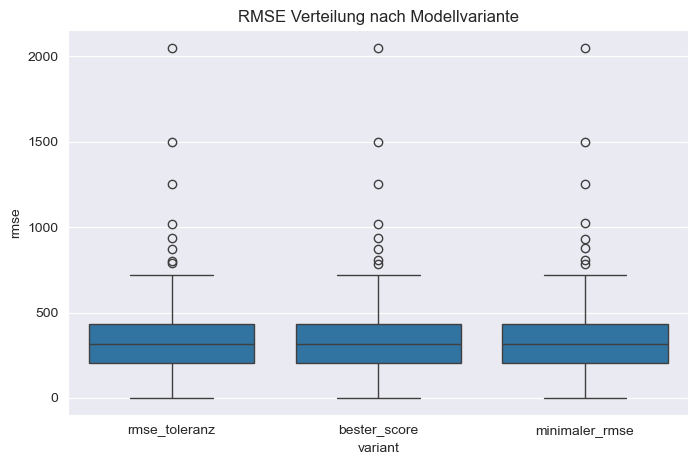

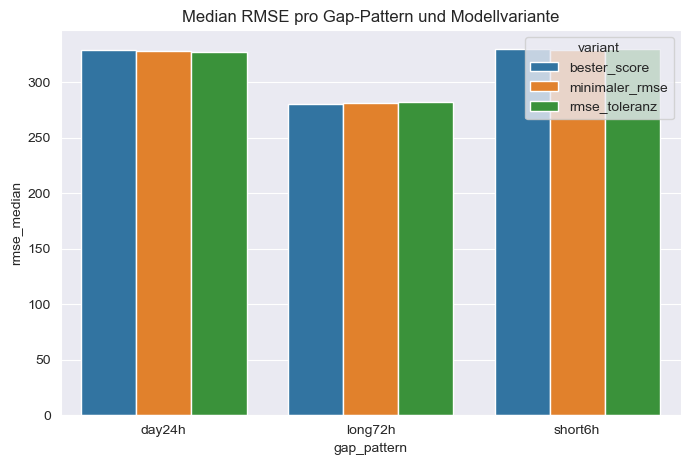

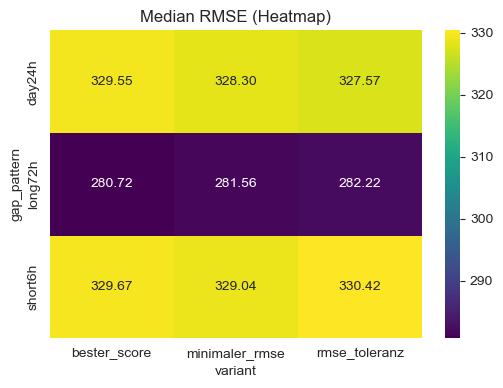

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/experiment_results/experiment_summary.csv")

# Boxplot: RMSE nach Modellvariante
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="variant", y="rmse")
plt.title("RMSE Verteilung nach Modellvariante")
plt.show()

# Grouped Barplot: median RMSE pro Gap-Pattern + Modell
pivot = (
    df.groupby(["gap_pattern","variant"])
      .agg(rmse_median=("rmse","median"))
      .reset_index()
)
plt.figure(figsize=(8,5))
sns.barplot(data=pivot, x="gap_pattern", y="rmse_median", hue="variant")
plt.title("Median RMSE pro Gap-Pattern und Modellvariante")
plt.show()

# Heatmap
heat = pivot.pivot(index="gap_pattern", columns="variant", values="rmse_median")
plt.figure(figsize=(6,4))
sns.heatmap(heat, annot=True, fmt=".2f", cmap="viridis")
plt.title("Median RMSE (Heatmap)")
plt.show()

In [24]:
def plot_imputation(series_key, variant, bin_key, gap_pattern,
                    base_dir="../data/experiment_results/imputed_series",
                    target_col="consumption"):
    """
    Visualisiert Original vs. Imputation für eine Serie mit synthetischer Lücke.

    Args:
        series_key: Name der Serie (z. B. "FL_00024360.PLAN.MengeHH.2")
        variant: Modellvariante ("rmse_toleranz", "bester_score", "minimaler_rmse")
        bin_key: Bin, in dem die Serie liegt ("0–5%", "10–15%", …)
        gap_pattern: Gap-Muster ("short6h", "day24h", "long72h")
        base_dir: Basisordner für gespeicherte Imputationsergebnisse
        target_col: Name der Zielspalte (Default: "consumption")
    """
    fn = Path(base_dir) / variant / bin_key / f"{series_key}__{gap_pattern}.parquet"
    if not fn.exists():
        raise FileNotFoundError(f"Datei nicht gefunden: {fn}")

    df = pd.read_parquet(fn)

    plt.figure(figsize=(12,5))
    plt.plot(df.index, df[target_col], label="Original", alpha=0.7, lw=2)
    plt.plot(df.index, df[f"{target_col}_imputed"], label="Imputation", alpha=0.7, lw=2)

    # Gap-Bereich farblich hervorheben
    mask = df[target_col].isna()
    if mask.any():
        plt.fill_between(df.index, df[f"{target_col}_imputed"].min(),
                         df[f"{target_col}_imputed"].max(),
                         where=mask, color="orange", alpha=0.2, label="synthetische Lücke")

    plt.title(f"{series_key} – {variant} – {gap_pattern}")
    plt.xlabel("Zeit")
    plt.ylabel("Verbrauch")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Beispielaufruf:
plot_imputation(
    series_key="FL_00024360.PLAN.MengeHH.2",
    variant="minimaler_rmse",
    bin_key="0–5%",
    gap_pattern="day24h"
)

FileNotFoundError: Datei nicht gefunden: ..\data\experiment_results\imputed_series\minimaler_rmse\0–5%\FL_00024360.PLAN.MengeHH.2__day24h.parquet

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
from typing import List, Optional, Tuple

# ------------------------
# SETTINGS (wie bei dir)
# ------------------------
BASE_DIR    = Path("../data")
MODELS_DIR  = BASE_DIR / "sarimax_models"
ASSIGN_FILE = BASE_DIR / "assignments" / "assignment_auto.csv"
FREQ        = "h"
TARGET_COL  = "consumption"

FEATURE_SETS = {
    "rmse_toleranz": ['hour','w_tl','w_ff','w_tb10','w_tb20','CEGH_WAP','THE_WAP'],
    "bester_score":  ['w_tl','w_tb10'],
    "minimaler_rmse":['hour','weekday','month','is_weekend','w_tl','w_rf','w_ff',
                      'w_ffx','w_cglo','w_so_h','w_rr','w_tb10','w_tb20','CEGH_WAP','THE_WAP']
}
TIME_FEATS = {"hour","weekday","month","is_weekend"}

# ------------------------
# HELPERS
# ------------------------
def load_model(medoid: str, variant: str):
    p = MODELS_DIR / f"{medoid}__{variant}.pkl"
    if not p.exists():
        raise FileNotFoundError(f"Modell fehlt: {p}")
    with open(p, "rb") as f:
        return pickle.load(f)

def prepare_df(df_raw: pd.DataFrame,
               target_col: str = TARGET_COL,
               freq: str = FREQ) -> pd.DataFrame:
    df = df_raw.copy()
    idx = pd.to_datetime(df.index)
    if getattr(idx, "tz", None) is not None:
        idx = idx.tz_convert("UTC").tz_localize(None)
    df.index = idx
    df = df[~df.index.duplicated(keep="first")].sort_index()
    df = df.asfreq(freq)  # erzeugt ggf. NaNs im Target -> so gewollt

    # Zeitfeatures sicherstellen
    if "hour" not in df.columns:     df["hour"]      = df.index.hour
    if "weekday" not in df.columns:  df["weekday"]   = df.index.weekday
    if "month" not in df.columns:    df["month"]     = df.index.month
    if "is_weekend" not in df.columns:
        df["is_weekend"] = (df.index.weekday >= 5).astype(int)
    else:
        df["is_weekend"] = df["is_weekend"].astype(int, errors="ignore")

    # Alle Nicht-Target- & Nicht-Zeitfeatures sanft auffüllen
    exog_cols = [c for c in df.columns if c not in {target_col, *TIME_FEATS}]
    if exog_cols:
        df[exog_cols] = (
            df[exog_cols].ffill().bfill().interpolate(method="time", limit_direction="both")
        )
    return df

def align_exogs_for_model(exog: pd.DataFrame, model_exog_names: List[str]) -> pd.DataFrame:
    miss = [c for c in model_exog_names if c not in exog.columns]
    extra = [c for c in exog.columns if c not in model_exog_names]
    if miss or extra:
        raise ValueError(f"Exog-Mismatch -> missing:{miss} extra:{extra}")
    return exog[model_exog_names]

def level_calibration(y_true: pd.Series, y_pred: pd.Series,
                      window_hours: int = 14*24) -> Tuple[float, float]:
    """
    Kalibriert (a + b*y_pred) anhand der ersten 'window_hours' nicht-NA Punkte.
    Gibt (a, b) zurück. Fallback: (0,1).
    """
    mask = y_true.notna() & y_pred.notna()
    if mask.sum() < 10:
        return 0.0, 1.0
    idx = y_true[mask].index[:window_hours]
    y = y_true.loc[idx]
    x = y_pred.loc[idx]
    # einfache robuste Schätzung: b = stdy/stdx (falls >0), a = median(y - b*x)
    sx = float(x.std())
    if sx <= 1e-12:
        return float(y.median() - x.median()), 1.0
    b = float(y.std() / sx)
    a = float((y - b*x).median())
    return a, b

def impute_with_applied_model(res,
                              y_nan: pd.Series,
                              exog_full: pd.DataFrame,
                              do_calibrate: bool = True) -> pd.Series:
    """
    Wendet die bereits gefitteten SARIMAX-Parameter auf *die gesamte Serie* an.
    Dadurch stimmen Länge/Index (keine 8760-vs-35058-Probleme).
    Optional: Level-Kalibrierung a+b*hat, um Regime-/Skalenwechsel abzufangen.
    """
    # Exognamen aus dem Trainingsmodell holen & exakt reordnen
    trained_names = getattr(getattr(res, "model", None), "exog_names", None)
    if trained_names is not None:
        exog_full = align_exogs_for_model(exog_full, trained_names)

    # Model auf neuen Datensatz "anwenden" (keine Neuschätzung der Parameter)
    res_applied = res.apply(endog=y_nan, exog=exog_full, refit=False)

    # Vorhersage über den kompletten Index
    pred = res_applied.get_prediction(start=y_nan.index[0],
                                      end=y_nan.index[-1]).predicted_mean

    # Level-Kalibrierung (kurzes Fenster)
    if do_calibrate:
        a, b = level_calibration(y_true=y_nan, y_pred=pred)
        pred = a + b*pred

    # Nur dort füllen, wo NaN war
    out = y_nan.copy()
    needs = out.isna()
    out.loc[needs] = pred.loc[needs]
    return out

# ------------------------
# QUICK PREVIEW / PLOT
# ------------------------
def quick_impute_preview(series_key: str,
                         df_raw: pd.DataFrame,
                         medoid: str,
                         variant: str,
                         features: List[str],
                         gap_pattern: Tuple[int, int] = (2, 24),
                         do_calibrate: bool = True):
    """
    Erzeugt synthetische Lücken, imputiert mit SARIMAX(medoid params) über die *volle* Serie
    und plottet Original vs. Imputation. gap_pattern=(n_windows, win_len_hours).
    """
    df = prepare_df(df_raw, target_col=TARGET_COL, freq=FREQ)

    # Exogene bauen (genau die Features der Variante)
    exog = df[features].copy()

    # Synthetische Lücken
    rng = np.random.default_rng(42)
    idx = df.index
    mask = pd.Series(False, index=idx)
    n, L = gap_pattern
    if len(idx) >= L:
        positions = np.arange(0, len(idx) - L + 1)
        rng.shuffle(positions)
        starts = []
        for p in positions:
            if all(abs(p - s) >= L for s in starts):
                starts.append(p)
                if len(starts) >= n:
                    break
        for s in starts:
            mask.loc[idx[s:s+L]] = True

    y = df[TARGET_COL].copy()
    y_nan = y.copy()
    y_nan.loc[mask] = np.nan

    # Modell laden & anwenden
    res = load_model(medoid, variant)
    y_imp = impute_with_applied_model(res, y_nan=y_nan, exog_full=exog, do_calibrate=do_calibrate)

    # Plot
    plt.figure(figsize=(13, 5))
    plt.plot(y.index, y, label="Original", lw=1.8, alpha=0.85)
    plt.plot(y_imp.index, y_imp, label="Imputation", lw=1.5, alpha=0.85)
    if mask.any():
        ymin = min(np.nanmin(y.values), np.nanmin(y_imp.values))
        ymax = max(np.nanmax(y.values), np.nanmax(y_imp.values))
        plt.fill_between(y.index, ymin, ymax, where=mask, alpha=0.15, label="synthetische Lücke")
    plt.title(f"{series_key} – {variant} (SARIMAX apply) – gaps={n}×{L}h")
    plt.xlabel("Zeit"); plt.ylabel("Verbrauch"); plt.legend(); plt.tight_layout(); plt.show()


In [26]:
df_raw = series_by_bin_loaded['0–5%']['FL_00024360.PLAN.MengeHH.2']

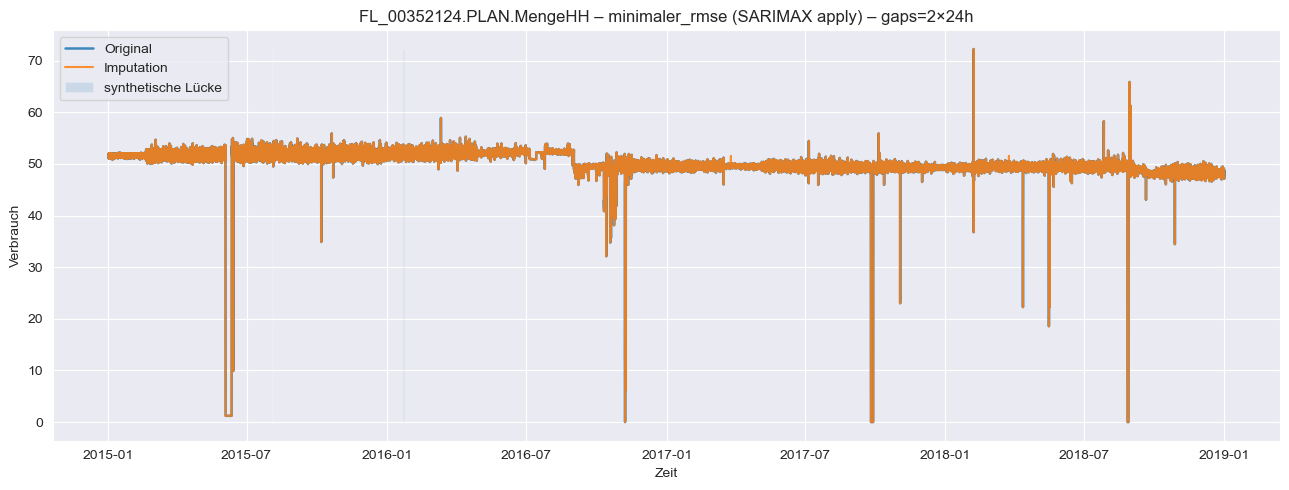

In [33]:
series_key = 'FL_00352124.PLAN.MengeHH'
variant    = "minimaler_rmse"
medoid     = "FL_00024360.PLAN.MengeGA"
features   = FEATURE_SETS[variant]

# df_raw ist deine Originalserie als DataFrame (Index=Datetime, Spalten inkl. 'consumption' + Exogs)
quick_impute_preview(series_key, df_raw, medoid, variant, features,
                     gap_pattern=(2, 24),    # 2 Fenster à 24h
                     do_calibrate=True)

In [30]:
series_by_bin_loaded['20–25%'].keys()

dict_keys(['FL_00352120.PLAN.MengeKW', 'FL_00024423.PLAN.MengeGA', 'FL_00352124.PLAN.MengeHH', 'FL_00352120.PLAN.MengeHH', 'FL_00352101.PLAN.MengeHH', 'FL_00025248.PLAN.MengeHH', 'FL_00352188.PLAN.MengeHH', 'CV_00349054.PLAN.Menge', 'CV_00349012.PLAN.Menge', 'CV_00349008.PLAN.Menge', 'CV_00006130.PLAN.Menge', 'CV_00005156.PLAN.Menge', 'CV_00003198.PLAN.Menge', 'CV_00003148.PLAN.Menge', 'CV_00003935.PLAN.Menge', 'CV_00003934.PLAN.Menge', 'CV_00003865.PLAN.Menge', 'CV_00003864.PLAN.Menge', 'CV_00003362.PLAN.Menge', 'CV_00003203.PLAN.Menge', 'CV_00003170.PLAN.Menge', 'CV_00003168.PLAN.Menge', 'CV_00003166.PLAN.Menge', 'CV_00003155.PLAN.Menge', 'CV_00003114.PLAN.Menge', 'CV_00002964.PLAN.Menge', 'CV_00002955.PLAN.Menge', 'CV_00002832.PLAN.Menge', 'CV_00003198.PLAN.Menge.1', 'CV_00007901.PLAN.Menge', 'CV_00003148.PLAN.Menge.1', 'CV_00006504.PLAN.Menge', 'CV_00006142.PLAN.Menge', 'CV_00003266.PLAN.Menge', 'CV_00003190.PLAN.Menge', 'CV_00003189.PLAN.Menge', 'CV_00003149.PLAN.Menge', 'CV_00003

In [32]:
assignment_auto[assignment_auto.series_key == 'FL_00352124.PLAN.MengeHH'] #'FL_00352124.PLAN.MengeHH'

,bin,series_key,assigned_medoid,distance
231,20–25%,FL_00352124.PLAN.MengeHH,FL_00024360.PLAN.MengeGA,4.109942
